# Reasoning without Obeservation

In [ReWOO](https://arxiv.org/abs/2305.18323), Xu, et. al, propose an agent that combines a multi-step planner and variable substitution for effective tool use. It was designed to improve on the ReACT-style agent architecture in the following ways:

1. Reduce token consumption and execution time by generating the full chain of tools used in a single pass. (ReACT-style agent architecture requires many LLM calls with redundant prefixes (since the system prompt and previous steps are provided to the LLM for each reasoning step)
2. Simplify the fine-tuning process. Since the planning data doesn't depend on the outputs of the tool, models can be fine-tuned without actually invoking the tools (in theory).

The following diagram outlines ReWOO's overall computation graph:

<img src="./images/reasoning_without_obesrvation.png">

ReWOO is made of 3 modules:

1. **🧠Planner**: Generate the plan in the following format:
```
Plan: <reasoning>
#E1 = Tool[argument for tool]
Plan: <reasoning>
#E2 = Tool[argument for tool with #E1 variable substitution]
...
```
2. **Worker**: executes the tool with the provided arguments.
3. **🧠Solver**: generates the answer for the initial task based on the tool observations.

The modules with a 🧠 emoji depend on an LLM call. Notice that we avoid redundant calls to the planner LLM by using variable substitution.

In this example, each module is represented by a LangGraph node. The end result will leave a trace that looks like [this one](https://smith.langchain.com/public/39dbdcf8-fbcc-4479-8e28-15377ca5e653/r). Let's get started!


## Setup

For this example, we will provide the agent with a Tavily search engine tool. You can get an API key [here](https://tavily.us.auth0.com/u/login/identifier?state=hKFo2SBENk9JcU42YXFxZVdKRnZqVi1HOTVhdFVRa0NOb0YwNaFur3VuaXZlcnNhbC1sb2dpbqN0aWTZIGdZS3VsWVhDQUoyaDZCTDFzeEczbEZsMV9ETDdKdS1mo2NpZNkgUlJJQXZ2WE5GeHBmVFdJb3pYMW1YcUxueVVtWVNUclE) or replace with a free tool option (e.g., duck duck go search).

Let's install the required packages and set our API keys

In [2]:
# !pip install -U langgraph langchain_community langchain_openai tavily-python

In [7]:
import os
import keyring

# API KEY
OPENAI_API_KEY = keyring.get_password('openai', 'key_for_mac')
ANTHROPIC_API_KEY = keyring.get_password('anthropic', 'key_for_mac')
TAVILY_API_KEY = keyring.get_password('tavily', 'key_for_mac')
GOOGLE_API_KEY = keyring.get_password('gemini', 'key_for_mac')


os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['ANTHROPIC_API_KEY'] = ANTHROPIC_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY

# Set up LangSmith observability
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['LANGCHAIN_API_KEY'] = keyring.get_password('langsmith', 'learning_agent')
os.environ['LANGCHAIN_PROJECT'] = "pr-stupendous-hood-8"

## Define graph state

In LangGraph, every node updates a shared graph state. The state is the input to any node whenever it is invoked.

Below, we will define a state dict to contain the task, plan, steps, and other variables.

In [3]:
from typing import List
from typing_extensions import TypedDict

class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

## Planner

The planner prompts an LLM to generate a plan in the form of a task list. The arguments to each task are strings that may contain special variables (`#E{0-9}+`) that are used for variable substitution from other task results.

<img src='./images/plan_execute_planner.png'>

Our example agent will have two tools: 1. Google - a search engine (in this case Tavily) 2. LLM - an LLM call to reason about previous outputs.

The LLM tool receives less of the prompt context and so can be more token-efficient than the ReACT paradigm.

In [16]:
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI

model = ChatOpenAI(model="gpt-4o-mini")
# model = ChatGoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=GOOGLE_API_KEY)

In [17]:
prompt = """For the following task, make plans that can solve the problem step by step.
For each plan, indicate which external tool together with tool input to retrieve evidence.
You can store the evidence into a variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. 
Useful when you need find short and succinct answers about a specific topic.
The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. 
Useful when you need to act with general world knowledge and common sence. 
Prioritize it when you are confident in solving the problem youself.
Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. 
Thomas worked x hours. Toby worked 10 hour less than twice that Thomas worked, and Rebecca worked 8 hours less than Toby.
How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve with Wolfram Alpha.
#E1 = WolframAlpha[Solve x + (2x - 10) + ((2x - 10) - 8) = 157]
Plan: Find out the number of hours Thomas worked.
#E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hour Rebecca worked. 
#E3 = Calculator[(2 * #E2 - 10) - 8]

Begin!
Describe your plan with rich details. 
Each Plan should be followed by only one #E.

Task: {task} 
"""

In [18]:
task = "what is the exact hometown of the 2024 mens austrailian open winner"

In [19]:
result = model.invoke(prompt.format(task=task))

In [20]:
print(result.content)

To determine the exact hometown of the 2024 men's Australian Open winner, I will take a step-by-step approach to gather the required information.

Plan: First, I will search for the winner of the 2024 men's Australian Open, as the tournament is still in the future. I need to find out who won to then lookup their hometown. I will utilize Google to retrieve this information.  
#E1 = Google["2024 men's Australian Open winner"]

Plan: Once I have identified the winner of the tournament, I will search for information regarding their hometown. This will provide me with the necessary details about where they are from. Here, I will again use Google to find this information based on the winner's name.  
#E2 = Google["hometown of [winner's name from #E1]"]

Plan: Finally, I will compile the findings from the previous steps into a concise response regarding the winner's exact hometown. This step does not require an external tool, as it will be based on the evidence gathered in #E1 and #E2.  
#E3 

### Planner Node

To connect the planner to our graph, we will create a `get_plan` node that accepts the `ReWOO` state and returns with a state update for the `steps` and `plan_string` fields.

In [36]:
import re

from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form E#... = ...[...]
rege_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | model

def get_plan(state: ReWOO):
    task = state["task"]
    result = planner.invoke({"task": task})
    # Find all matches in the sample text
    matches = re.findall(rege_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}

## Executor

The executor receives the plan and executes the tools in sequence.

Below, instantiate the search engine and define the tool execution node.

In [37]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults()

In [50]:
def _get_current_task(state: ReWOO):
    if "results" not in state or state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1
    
def tool_execution(state: ReWOO):
    """Worker node that executes the tools of a given plan."""
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    _results = (state["results"] or {}) if "results" in state else {}
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v)
    if tool == "Google":
        result = search.invoke(tool_input)
    elif tool == "LLM":
        result = model.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    return {"results": _results}

## Solver

The solver receives the full plan and generates the final response based on the responses of the tool calls from the worker.

In [56]:
solve_prompt = """Solve the following task or problem.
To solve the problem, we have made step-by-step Plan and retrieved corresponding Evidence to each Plan.
Use them with caution since long evidence might contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above.
Respond with the answer directly with no exra words.

Task: {task}
Respnse:"""

def solve(state: ReWOO):
    plan = ""
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = (state["results"] or {}) if "results" in state else {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = model.invoke(prompt)
    return {"result": result.content}

## Define Graph

Our graph defines the workflow. Each of the planner, tool executor, and solver modules are added as nodes.

In [57]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"

In [58]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(ReWOO)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

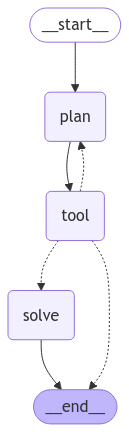

In [59]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [60]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'steps': [("First, I need to retrieve information about the 2024 men's Australian Open winner. This includes checking sports news outlets or official tournament sources for the latest updates on the tournament. I'll perform a Google search for the winner's information.", '#E1', 'Google', "2024 men's Australian Open winner"), ("Once I have the name of the winner from #E1, I will look for their hometown. This may involve searching their biography or relevant sports profiles to find their exact hometown. I'll search for this information using Google.", '#E2', 'Google', "What is the hometown of [winner's name from #E1"), ("Compile and summarize the findings from #E2 to provide the final answer regarding the exact hometown of the 2024 men's Australian Open winner.", '#E3', 'LLM', 'Summarize the hometown from #E2')], 'plan_string': "Plan: First, I need to retrieve information about the 2024 men's Australian Open winner. This includes checking sports news outlets or official tournam